# Merchant EDA – Univariate & Multivariate
Goal: Analyze merchant-level attributes and their relationship with historical fraud


In [32]:
from pathlib import Path
from typing import Any

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import ndarray, dtype

from mastercard_challenge.visualization.visualize import dist_visualisation, plot_categorical_distributions, plot_correlation_matrix

In [3]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

DATA_PROCESSED_DIR = Path("../data/processed")
DATA_INTERIM_DIR = Path("../data/interim")

In [4]:
df = pd.read_parquet(DATA_PROCESSED_DIR / "merchants.parquet")

In [10]:
print("Initial shape:", df.shape)

Initial shape: (1000, 8)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   merchant_id                     1000 non-null   object 
 1   category                        1000 non-null   object 
 2   country                         1000 non-null   object 
 3   trust_score                     1000 non-null   float64
 4   number_of_alerts_last_6_months  1000 non-null   int64  
 5   avg_transaction_amount          1000 non-null   float64
 6   account_age_months              1000 non-null   int64  
 7   has_fraud_history               1000 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 62.6+ KB


In [6]:
df.head()

,merchant_id,category,country,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,M0001,travel,Austria,1.000000,3,97.23,84,0
1,M0002,clothing,Poland,0.689695,2,142.71,93,1
2,M0003,electronics,Czech Republic,0.834610,5,67.83,65,0
3,M0004,electronics,Belgium,0.607229,1,16.77,9,1
4,M0005,grocery,Ireland,0.641901,2,38.56,100,0


In [9]:
df.describe()

,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,0.682568,3.06100,81.883090,61.526000,0.52000
std,0.194092,1.72286,79.187529,33.453617,0.49985
min,0.000000,0.00000,0.120000,6.000000,0.00000
25%,0.545615,2.00000,24.772500,32.000000,0.00000
50%,0.697414,3.00000,58.205000,61.000000,1.00000
75%,0.825599,4.00000,117.192500,92.000000,1.00000
max,1.000000,9.00000,709.040000,119.000000,1.00000


## 1. Data Type Fixing and Basic Cleaning


In [11]:

df['merchant_id'] = df['merchant_id'].astype('category')
df['category'] = df['category'].astype('category')
df['country'] = df['country'].astype('category')
df['has_fraud_history'] = df['has_fraud_history'].astype('category')

## 2. Univariate Analysis – Categorical Features

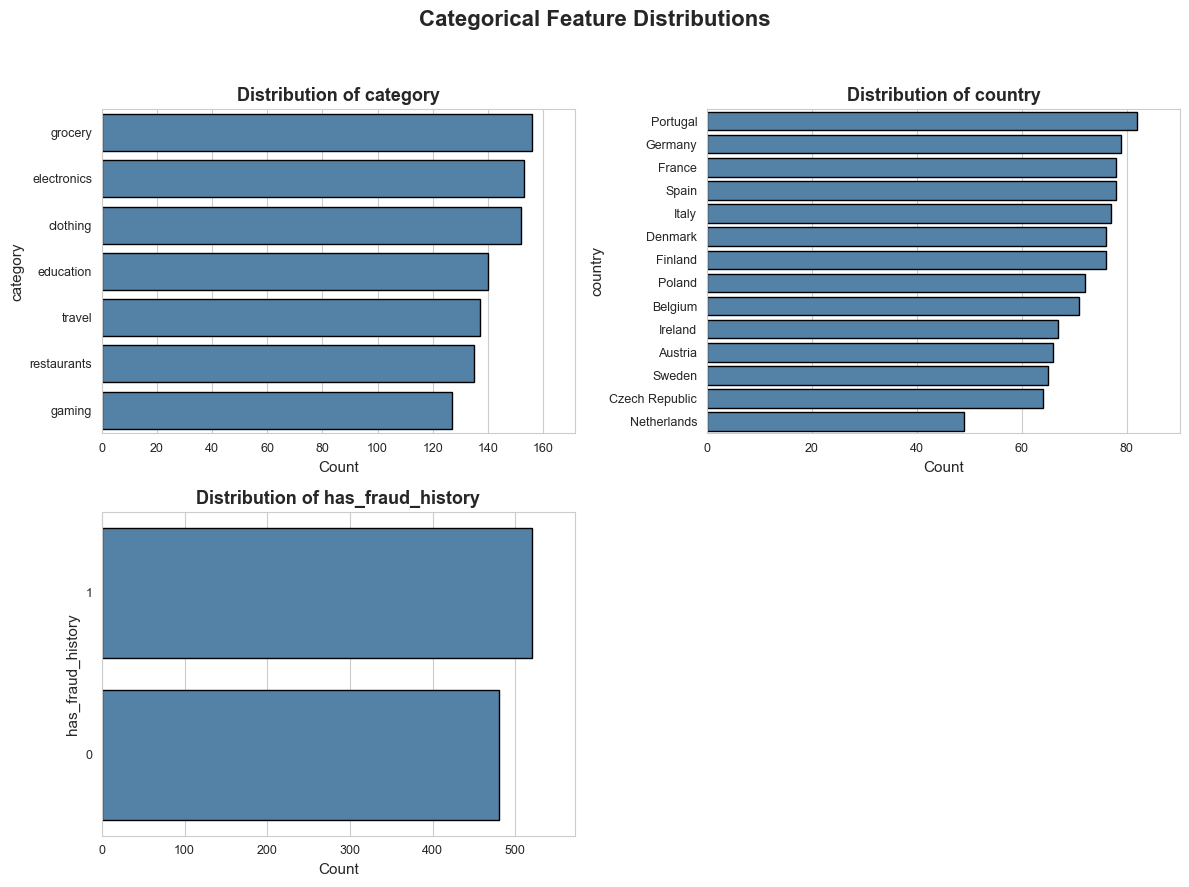

In [15]:
categorical_cols = ['category', 'country', 'has_fraud_history']
plot_categorical_distributions(df, categorical_cols)

### Observations – Categorical Feature Distributions

#### Category
- The distribution of merchant categories is relatively balanced across all segments (grocery, electronics, clothing, travel, education, restaurants, gaming).
- Grocery merchants are the most common, followed closely by electronics and clothing.

#### Country
- The merchants are evenly distributed across European countries.
- Portugal has the highest number of merchants, while the Netherlands has the fewest.

#### Has Fraud History
- The binary variable `has_fraud_history` is almost perfectly balanced: ~50% of merchants have been previously associated with fraudulent behavior.
- This balance is valuable for training classification models, as we avoid strong class imbalance.

### 3. Univariate Analysis – Numerical Features

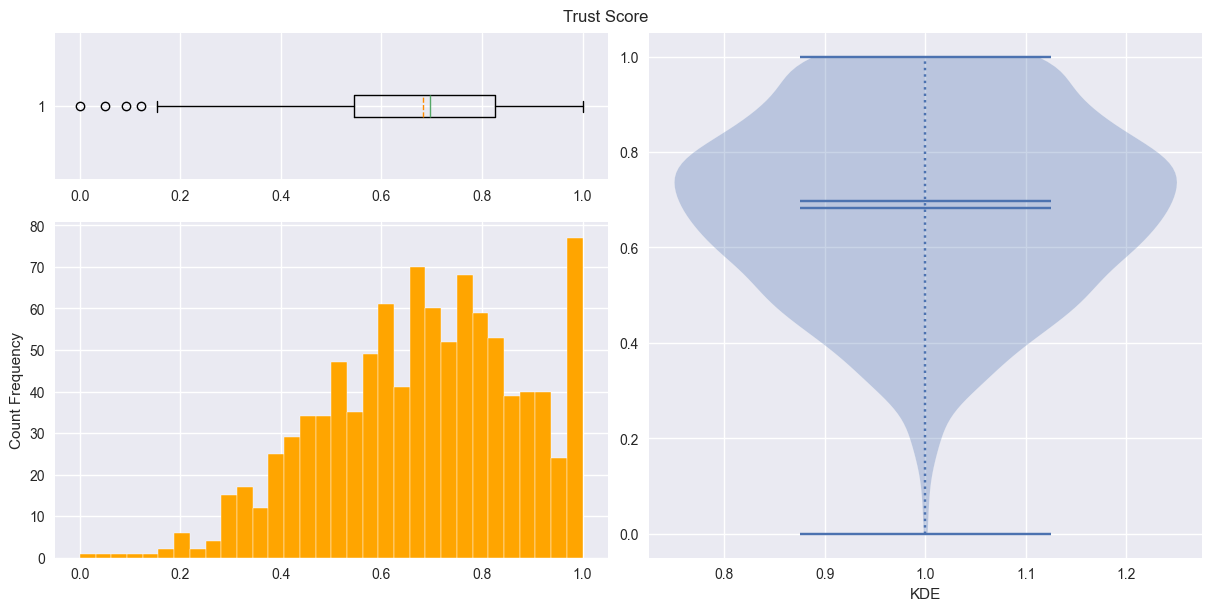

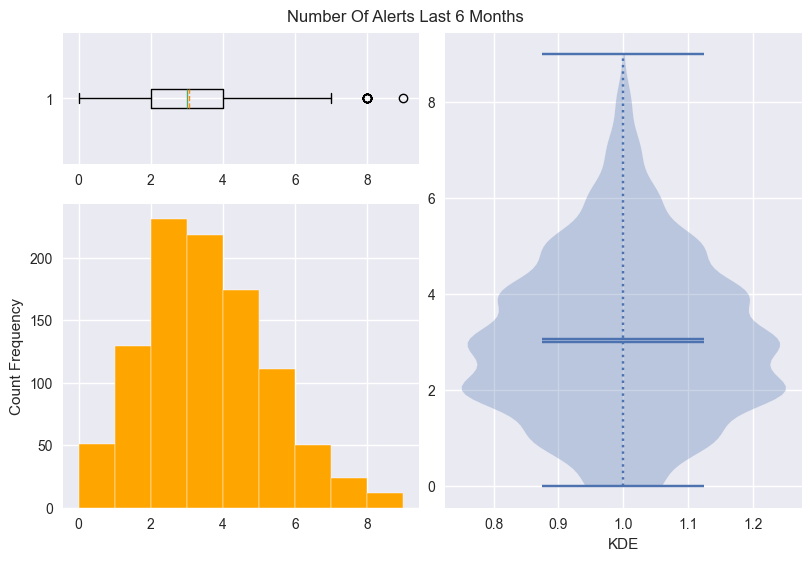

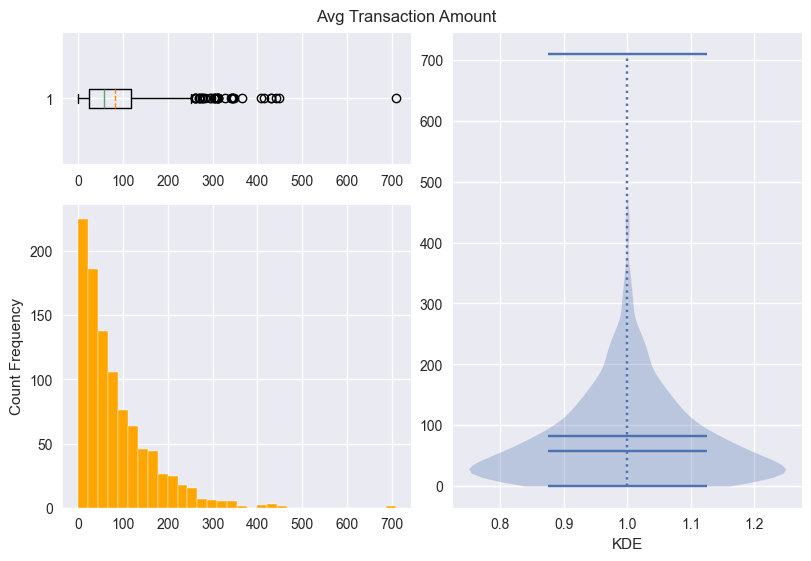

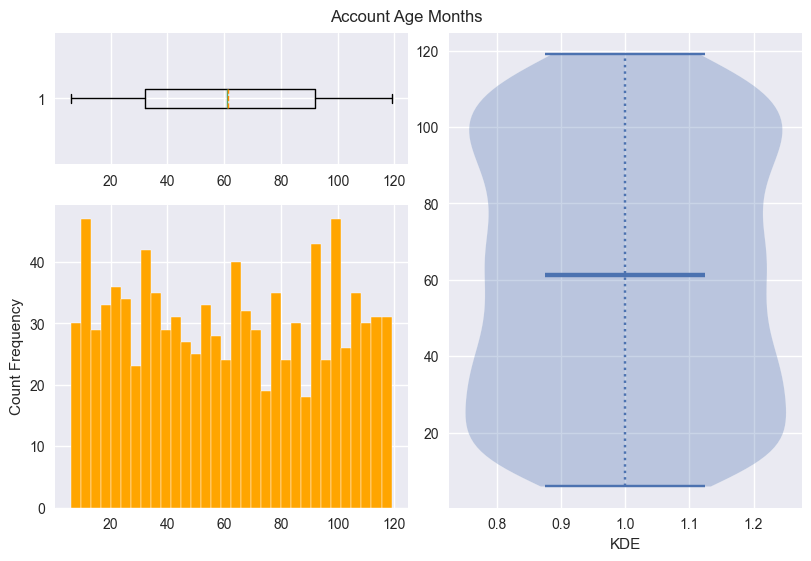

In [16]:
numerical_cols = ['trust_score', 'number_of_alerts_last_6_months', 'avg_transaction_amount', 'account_age_months']

for col in numerical_cols:
    dist_visualisation(df[col], col.title().replace("_", " "))

#### Univariate Analysis – Numerical Features

trust_score
 - The distribution is right-skewed, concentrated in the range of 0.5 to 1.0, with many values close to 1.0.
 - A few very low values (near 0.0) are present, possibly due to noise or rare edge cases.
 - Recommendations:
 - Consider capping or transforming (e.g., logit transformation) if downstream models are sensitive to extreme values.

number_of_alerts_last_6_months
 - The feature resembles a Poisson distribution, with a peak around 2–3 alerts.
 - Rare cases of high alert counts (up to 9) may be strong fraud indicators.
 - Recommendations:
 - Consider binning into groups (e.g., 0, 1–3, >3) to reduce noise and improve model interpretability.

avg_transaction_amount
 - Highly right-skewed distribution with most transactions below 200 EUR.
 - The mean is around 82 EUR, with some significant outliers reaching up to 709 EUR.
 - Recommendations:
 - Apply a log transformation to reduce skewness.
 - Optionally cap values at the 99th percentile if extreme values dominate model behavior.

account_age_months
 - The distribution is fairly uniform, ranging from 6 to 119 months.
 - No significant outliers observed.
 - Recommendations:
 - This feature may be used as-is.
 - Alternatively, bucketize into categories like:
 - New: <12 months
 - Mid: 12–36 months
 - Established: >36 months

In [18]:
df["log_avg_transaction_amount"] = np.log1p(df["avg_transaction_amount"])

In [23]:
def bin_alerts_vectorized(series: pd.Series) -> Any:
    """
    Vectorized binning of alert counts into categorical labels.

    Args:
        series: A Pandas Series with integer counts of alerts.

    Returns:
        A Series with categorical labels: "0", "1-3", or "4+".
    """
    conditions = [
        (series == 0),
        (series.between(1, 3)),
        (series > 3)
    ]
    choices = ["0", "1-3", "4+"]

    return np.select(conditions, choices, default="unknown")

In [24]:
df["alerts_binned"] = bin_alerts_vectorized(df["number_of_alerts_last_6_months"])

In [26]:
def age_bucket_vectorized(series: pd.Series) -> Any:
    """
    Vectorized version of age_bucket() for Pandas Series.

    Args:
        series: Series of account ages in months.

    Returns:
        Series with age bucket labels.
    """
    conditions = [
        (series < 12),
        (series.between(12, 36)),
        (series > 36)
    ]
    choices = ["New", "Mid", "Established"]
    return np.select(conditions, choices, default="Unknown")

In [27]:
df["account_age_group"] = age_bucket_vectorized(df["account_age_months"])

In [31]:
df[[
    "log_avg_transaction_amount",
    "number_of_alerts_last_6_months", "alerts_binned",
    "account_age_months", "account_age_group"
]].head()

,log_avg_transaction_amount,number_of_alerts_last_6_months,alerts_binned,account_age_months,account_age_group
0,4.587312,3,1-3,84,Established
1,4.967797,2,1-3,93,Established
2,4.231640,5,4+,65,Established
3,2.877512,1,1-3,9,New
4,3.677819,2,1-3,100,Established


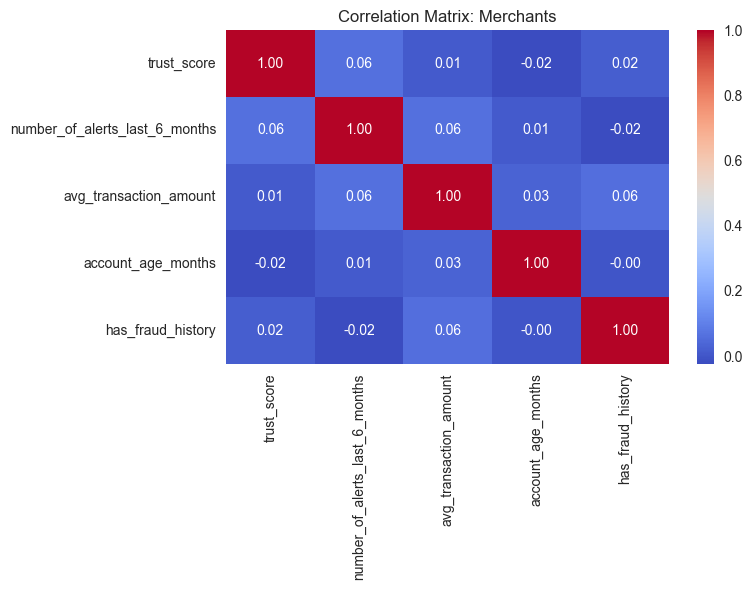

In [34]:
# Correlation Matrix (Numerical Features)

numeric_cols = [
    "trust_score",
    "number_of_alerts_last_6_months",
    "avg_transaction_amount",
    "account_age_months",
    "has_fraud_history"
]

plot_correlation_matrix(df, cols=numeric_cols, title="Correlation Matrix: Merchants")

### Correlation Insights (Merchants)

#### 1. General Observations
- All correlation values are relatively low (|r| < 0.1), indicating **very weak linear relationships** between the features.
- This suggests that multicollinearity is not a concern in this dataset.

#### 2. Specific Relationships
- **`number_of_alerts_last_6_months` and `avg_transaction_amount`** show the strongest positive correlation (r = 0.06), although still weak.
- **`trust_score` and `number_of_alerts_last_6_months`** also exhibit a weak positive correlation (r = 0.06), indicating that merchants with more alerts tend to have slightly higher trust scores, which might be counterintuitive and worth further analysis.
- **`account_age_months`** shows almost no correlation with any other variable, which suggests account age might be independent in its relationship to fraud or trust.
- **`has_fraud_history`** has weak or near-zero correlations with all numerical features, especially:
  - `trust_score` (r = 0.02)
  - `avg_transaction_amount` (r = 0.06)
  - `account_age_months` (r ≈ 0.00)

#### 3. Implications
- Since no strong linear associations are observed, predictive models might benefit more from **non-linear relationships**, **interactions**, or **categorical variables** such as `category` or `country`.
- Feature engineering (e.g. binning, ratios) or tree-based models might capture more complex patterns that are not reflected in the Pearson correlation matrix.

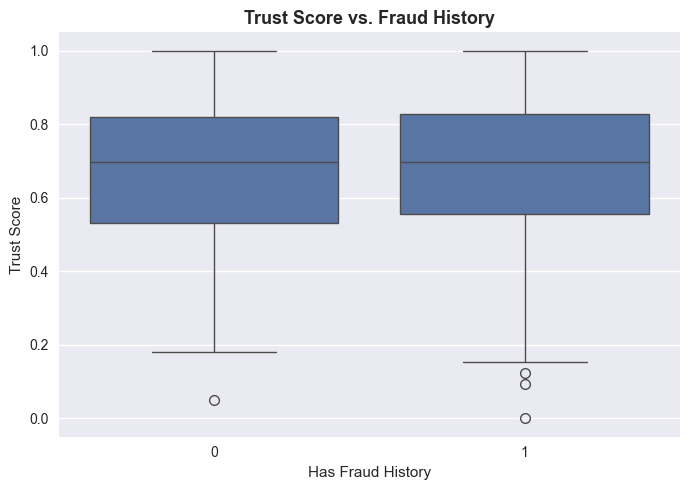

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, x="has_fraud_history", y="trust_score", ax=ax)

ax.set_title("Trust Score vs. Fraud History", fontsize=13, weight="bold")
ax.set_xlabel("Has Fraud History", fontsize=11)
ax.set_ylabel("Trust Score", fontsize=11)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

fig.tight_layout()
plt.show()

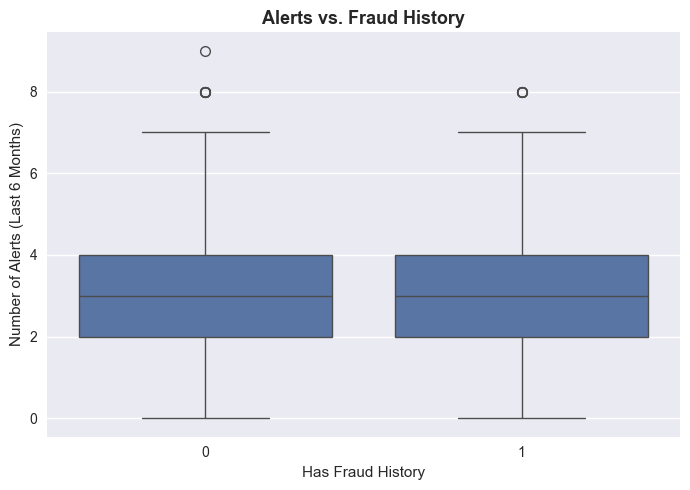

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, x="has_fraud_history", y="number_of_alerts_last_6_months", ax=ax)

ax.set_title("Alerts vs. Fraud History", fontsize=13, weight="bold")
ax.set_xlabel("Has Fraud History", fontsize=11)
ax.set_ylabel("Number of Alerts (Last 6 Months)", fontsize=11)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

fig.tight_layout()
plt.show()

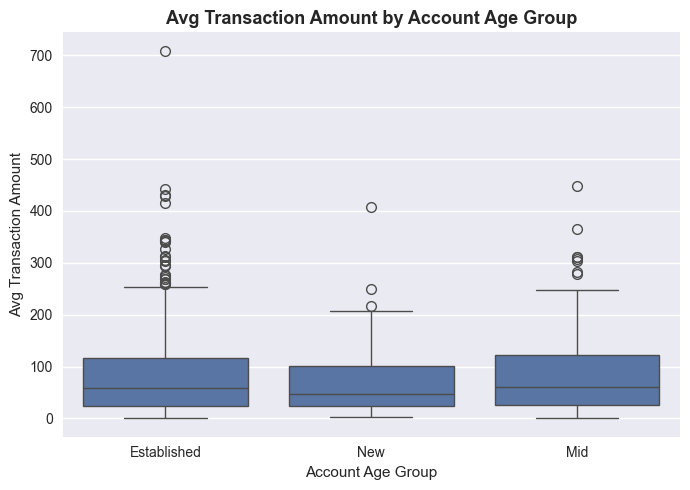

In [37]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, x="account_age_group", y="avg_transaction_amount", ax=ax)

ax.set_title("Avg Transaction Amount by Account Age Group", fontsize=13, weight="bold")
ax.set_xlabel("Account Age Group", fontsize=11)
ax.set_ylabel("Avg Transaction Amount", fontsize=11)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

fig.tight_layout()
plt.show()

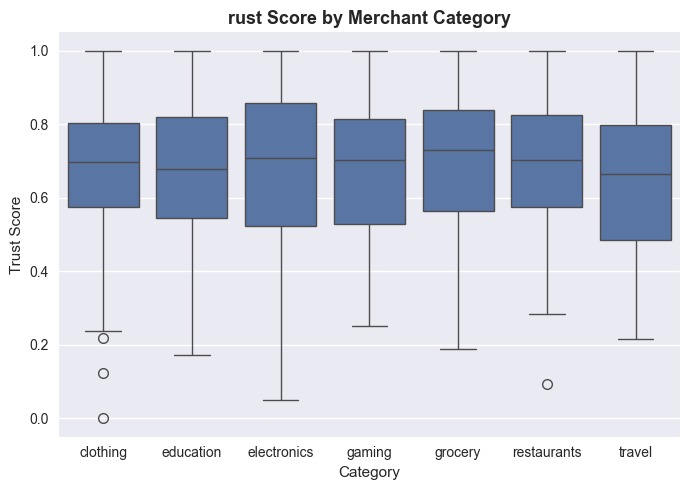

In [38]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, x="category", y="trust_score", ax=ax)

ax.set_title("rust Score by Merchant Category", fontsize=13, weight="bold")
ax.set_xlabel("Category", fontsize=11)
ax.set_ylabel("Trust Score", fontsize=11)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

fig.tight_layout()
plt.show()

###  Multivariate Analysis Insights – Merchants Dataset

#### 1. Trust Score vs. Fraud History
Merchants with and without a fraud history exhibit very similar trust score distributions. This suggests that trust score alone may not be a strong discriminator for detecting prior fraud behavior.

#### 2. Number of Alerts vs. Fraud History
There is a slight increase in the number of alerts for merchants with fraud history, but the distributions overlap considerably. This implies only a weak relationship between the number of alerts and prior fraud.

#### 3. Avg Transaction Amount by Account Age Group
Average transaction amounts are relatively consistent across account age groups ("New", "Mid", and "Established"), though outliers are more prevalent in older accounts. This suggests that account age may not be a strong predictor of transaction value.

#### 4. Trust Score by Merchant Category
The distribution of trust scores across categories is fairly uniform. However, the "electronics" and "education" categories have slightly wider interquartile ranges, indicating higher variability in merchant reputation within these sectors.

In [39]:
df.to_parquet(DATA_INTERIM_DIR / "merchants_binned.parquet", index=False)